# b-value difference

this notebook is about differences in b-values at different times

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata


In [2]:
df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0}
eq = kumamoto
df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=75, m=1)
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

In [3]:
results_df = pd.read_csv('average_b_value_spatial_map_kumamoto.csv')
results_avg = results_df.groupby(['lon', 'lat', 'start_time']).mean().reset_index()
results_2000 = results_avg[results_avg.start_time < '2005']
results_2010 = results_avg[results_avg.start_time > '2005']
results_avg = results_2000.merge(results_2010, on=['lon', 'lat'])
results_avg['b_diff'] = -1.*(results_avg.b_x - results_avg.b_y)

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]


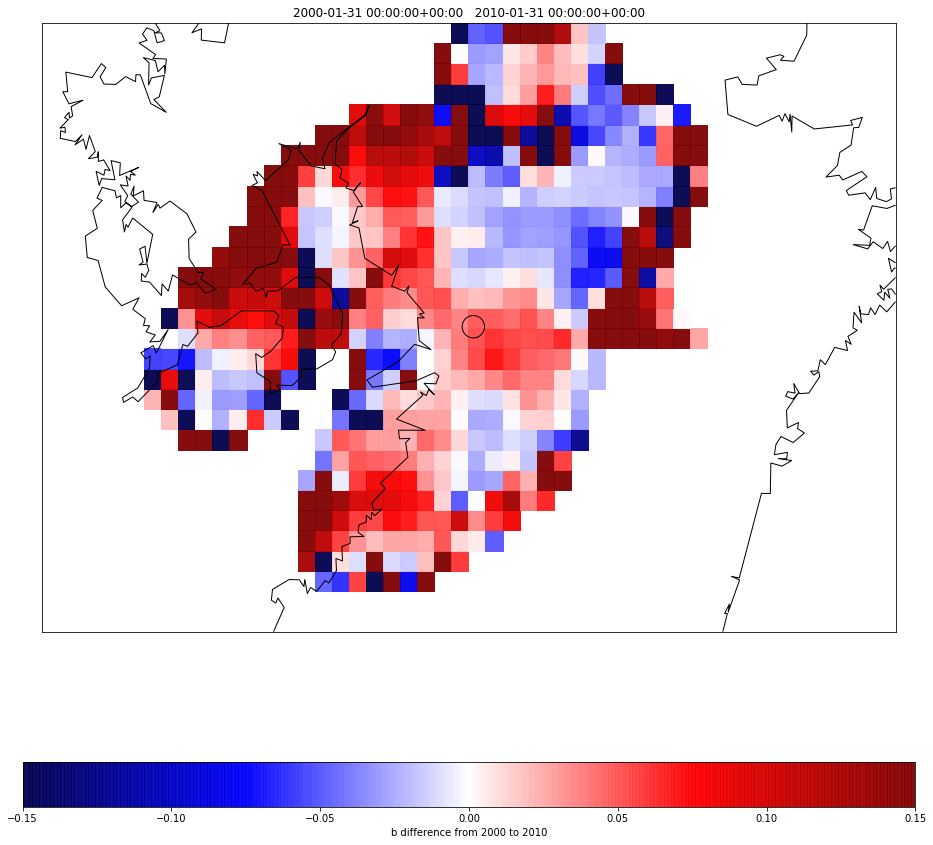

In [77]:
fig, ax = plt.subplots(figsize=(16, 16))


lons = results_avg.lon.values
lats = results_avg.lat.values

lat_min = lats.min()
lat_max = lats.max()
lon_min = lons.min()
lon_max = lons.max()

lon_i = np.linspace(lon_min, lon_max, (lon_max - lon_min)/0.05 + 1)
lat_i = np.linspace(lat_min, lat_max, (lat_max - lat_min)/0.05 + 1)


m = Basemap(projection='merc'
           ,llcrnrlat=lat_min
           ,urcrnrlat=lat_max
           ,llcrnrlon=lon_min
           ,urcrnrlon=lon_max
           ,resolution='i'
           ,area_thresh=1000
           ,ax=ax)

m.drawcoastlines()

data = results_avg.copy()

n_remove = 250
# print('shape', data.shape)
# print('data copy', data[data.n_x < n_remove].b_x.describe())
data.ix[data.n_x < n_remove, 'b_x'] = np.nan
data.ix[data.n_y < n_remove, 'b_y'] = np.nan
data.ix[data.n_x < n_remove, 'b_diff'] = np.nan
data.ix[data.n_y < n_remove, 'bdiff'] = np.nan
# print('data removal', data[data.n_x < n_remove].b_x.describe())

zi = data.pivot(index='lat', columns='lon', values='b_diff').values

xi, _yi = m(lon_i, np.zeros_like(lon_i))
_xi, yi = m(np.zeros_like(lat_i), lat_i)

x, y = m(lons, lats)

xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi)
# >>> ma.masked_where(a <= 2, a)
# zi = np.ma.masked_where(zi > 2.0, zi)
# zi = np.ma.masked_where(zi < 0.5, zi)

cbar = ax.pcolormesh(xi, yi, zi, cmap='seismic', vmin=-0.15, vmax=0.15, alpha=0.95)

fig.colorbar(cbar, label='b difference from 2000 to 2010', orientation='horizontal')
ax.set_title(data.start_time_x.head(1)[0] + '   ' + data.start_time_y.head(1)[0])

x, y = m(eq['coordinates'][0], eq['coordinates'][1])
ax.scatter(x, y, s=500, color='None', edgecolor='black')

In [10]:
slip_df = pd.read_csv('data//Kumamoto_slip_uchide20160923.txt', delim_whitespace=True, names=['lat', 'lon', 'depth', 'slip'])

In [39]:
slip_df.head()

,lat,lon,depth,slip,projected_lon,projected_lat
0,32.7551,130.8143,0.16,2.036,146143.423272,99420.469579
1,32.7510,130.8120,0.16,1.716,145887.675062,98878.384623
2,32.7469,130.8097,0.16,1.398,145631.926851,98336.324619
3,32.7428,130.8075,0.16,1.084,145387.298127,97794.289561
4,32.7388,130.8052,0.16,0.781,145131.549916,97265.498907


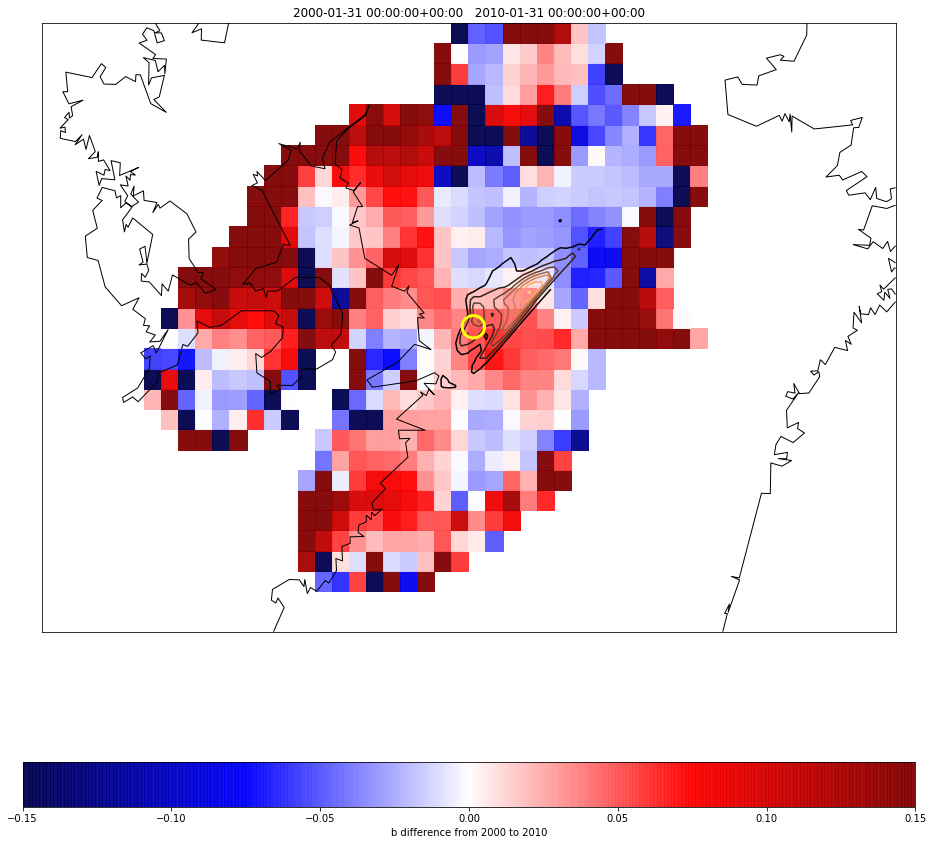

In [40]:
zoom = 0.0

fig, ax = plt.subplots(figsize=(16, 16))
m = Basemap(projection='merc'
           ,llcrnrlat=lat_min + zoom
           ,urcrnrlat=lat_max - zoom
           ,llcrnrlon=lon_min + zoom
           ,urcrnrlon=lon_max - zoom
           ,resolution='i'
           ,area_thresh=1000
           ,ax=ax)

m.drawcoastlines()


numcols, numrows = 30, 30
levels = 7

slip_df['projected_lon'], slip_df['projected_lat'] = m(*(slip_df.lon.values, slip_df.lat.values))
xi = np.linspace(slip_df.projected_lon.min(), slip_df.projected_lon.max(), numcols)
yi = np.linspace(slip_df.projected_lat.min(), slip_df.projected_lat.max(), numrows)
xi, yi = np.meshgrid(xi, yi)
x, y, z = slip_df.projected_lon.values, slip_df.projected_lat.values, slip_df.slip.values
zi = griddata(x, y, z, xi, yi, interp='linear')
# im = ax.contourf(xi, yi, zi, levels, cmap='hot', alpha=0.75)
im2 = ax.contour(xi, yi, zi, levels, cmap='copper', )


zi = data.pivot(index='lat', columns='lon', values='b_diff').values

xi, _yi = m(lon_i, np.zeros_like(lon_i))
_xi, yi = m(np.zeros_like(lat_i), lat_i)

x, y = m(lons, lats)

xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi)
# >>> ma.masked_where(a <= 2, a)
# zi = np.ma.masked_where(zi > 2.0, zi)
# zi = np.ma.masked_where(zi < 0.5, zi)

cbar = ax.pcolormesh(xi, yi, zi, cmap='seismic', vmin=-0.15, vmax=0.15, alpha=0.95)

fig.colorbar(cbar, label='b difference from 2000 to 2010', orientation='horizontal')
ax.set_title(data.start_time_x.head(1)[0] + '   ' + data.start_time_y.head(1)[0])

x, y = m(eq['coordinates'][0], eq['coordinates'][1])
ax.scatter(x, y, s=500, color='None', edgecolor='yellow', linewidth=3, zorder=10)

In [44]:
def round_nearest(x, a):
    return round(x / a) * a

In [46]:
slip_df['lon_bins'] = slip_df.lon.apply(lambda x: round_nearest(x, 0.05))
slip_df['lat_bins'] = slip_df.lat.apply(lambda x: round_nearest(x, 0.05))

In [48]:
slip_df.dtypes

lat              float64
lon              float64
depth            float64
slip             float64
projected_lon    float64
projected_lat    float64
lon_bins         float64
lat_bins         float64
dtype: object

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


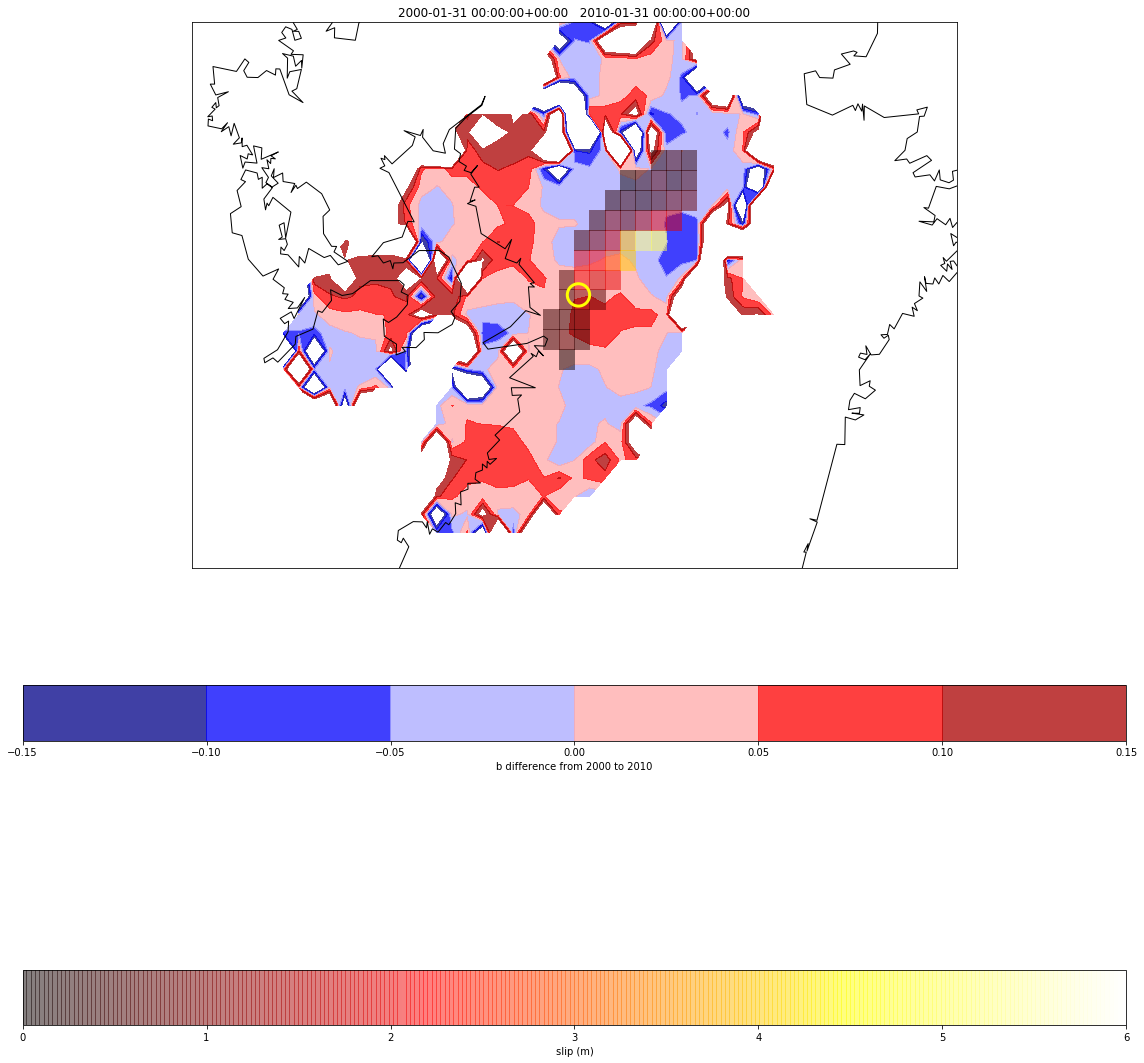

In [126]:
zoom = 0.0

fig, ax = plt.subplots(figsize=(16, 16))
m = Basemap(projection='merc'
           ,llcrnrlat=lat_min + zoom
           ,urcrnrlat=lat_max - zoom
           ,llcrnrlon=lon_min + zoom
           ,urcrnrlon=lon_max - zoom
           ,resolution='i'
           ,area_thresh=1000
           ,ax=ax)

m.drawcoastlines()


# numcols, numrows = 30, 30
# levels = 7

# slip_df['projected_lon'], slip_df['projected_lat'] = m(*(slip_df.lon.values, slip_df.lat.values))
# xi = np.linspace(slip_df.projected_lon.min(), slip_df.projected_lon.max(), numcols)
# yi = np.linspace(slip_df.projected_lat.min(), slip_df.projected_lat.max(), numrows)
# xi, yi = np.meshgrid(xi, yi)
# x, y, z = slip_df.projected_lon.values, slip_df.projected_lat.values, slip_df.slip.values
# zi = griddata(x, y, z, xi, yi, interp='linear')
# # im = ax.contourf(xi, yi, zi, levels, cmap='hot', alpha=0.75)
# im2 = ax.contour(xi, yi, zi, levels, cmap='copper', )

slip_lon_min = slip_df['lon_bins'].min()
slip_lon_max = slip_df['lon_bins'].max()
slip_lat_min = slip_df['lat_bins'].min()
slip_lat_max = slip_df['lat_bins'].max()

slip_lon_i = np.linspace(slip_lon_min, slip_lon_max, (slip_lon_max - slip_lon_min)/0.05 + 1)
slip_lat_i = np.linspace(slip_lat_min, slip_lat_max+0.05, (slip_lat_max+0.05 - slip_lat_min)/0.05 + 1)

zi = slip_df.pivot_table(index='lat_bins', columns='lon_bins', values='slip', aggfunc=np.median).values

xi, _yi = m(slip_lon_i, np.zeros_like(slip_lon_i))
_xi, yi = m(np.zeros_like(slip_lat_i), slip_lat_i)

x, y = m(lons, lats)

xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi)
# >>> ma.masked_where(a <= 2, a)
# zi = np.ma.masked_where(zi > 2.0, zi)
# zi = np.ma.masked_where(zi < 0.5, zi)

cbar = ax.pcolormesh(xi, yi, zi, cmap='hot', vmin=0, vmax=6, alpha=0.5)
# cbar = ax.contour(xi, yi, zi, cmap='jet',levels=)

fig.colorbar(cbar, label='slip (m)', orientation='horizontal')
# ax.set_title(data.start_time_x.head(1)[0] + '   ' + data.start_time_y.head(1)[0])

x, y = m(eq['coordinates'][0], eq['coordinates'][1])
ax.scatter(x, y, s=500, color='None', edgecolor='yellow', linewidth=3, zorder=10)

########################################

zi = data.pivot(index='lat', columns='lon', values='b_diff').values

xi, _yi = m(lon_i, np.zeros_like(lon_i))
_xi, yi = m(np.zeros_like(lat_i), lat_i)

x, y = m(lons, lats)

xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi)
# >>> ma.masked_where(a <= 2, a)
# zi = np.ma.masked_where(zi > 2.0, zi)
# zi = np.ma.masked_where(zi < 0.5, zi)

cbar = ax.contourf(xi, yi, zi, vmin=-0.15, vmax=0.15, zorder=0
                   , alpha=0.75, levels=[-0.15, -0.1, -0.05, 0.0, 0.05, 0.1, 0.15]
                  ,cmap='seismic')

# cbar = ax.pcolormesh(xi, yi, zi, cmap='seismic', vmin=-0.15, vmax=0.15, alpha=0.95)

fig.colorbar(cbar, label='b difference from 2000 to 2010', orientation='horizontal')
ax.set_title(data.start_time_x.head(1)[0] + '   ' + data.start_time_y.head(1)[0])


plt.tight_layout()

In [91]:
results_avg.head(1)

,lon,lat,start_time_x,radius_x,a_x,b_x,bstd_x,n_x,mc_x,start_time_y,radius_y,a_y,b_y,bstd_y,n_y,mc_y,b_diff
0,129.5,32.0,2000-01-31 00:00:00+00:00,14.5,NaN,NaN,NaN,NaN,NaN,2010-01-31 00:00:00+00:00,14.5,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
slip_df.head(1)

,lat,lon,depth,slip,projected_lon,projected_lat,lon_bins,lat_bins
0,32.7551,130.8143,0.16,2.036,146143.423272,99420.469579,130.8,32.75


In [98]:
slip_df_joinable = slip_df.copy()
slip_df_joinable.columns = ['lat_old', 'lon_old' ,'depth', 'slip', 'projected_lon', 'projected_lat', 'lon', 'lat']

In [100]:
slip_b_df = results_avg.merge(slip_df_joinable, on=['lon', 'lat'])

In [101]:
slip_b_df.describe()

,lon,lat,radius_x,a_x,b_x,bstd_x,n_x,mc_x,radius_y,a_y,...,bstd_y,n_y,mc_y,b_diff,lat_old,lon_old,depth,slip,projected_lon,projected_lat
count,4259.000000,4259.000000,4259.0,4259.000000,4259.000000,4259.000000,4259.000000,4259.000000,4259.0,4259.000000,...,4259.000000,4259.000000,4259.000000,4259.000000,4259.000000,4259.000000,4259.000000,4259.000000,4259.000000,4259.000000
mean,130.881956,32.849084,14.5,3.906593,0.817670,0.019235,2943.047370,0.700929,14.5,3.474783,...,0.031311,1184.481392,0.710042,-0.001921,32.849490,130.881377,10.881775,1.102488,153601.996348,111918.326010
std,0.134376,0.122634,0.0,0.092417,0.078851,0.004870,432.338881,0.002483,0.0,0.162344,...,0.004698,355.610582,0.016694,0.038230,0.122276,0.133616,6.592629,0.985747,14857.379200,16179.782642
min,130.650000,32.600000,14.5,3.595124,0.709438,0.012759,1759.150000,0.700000,14.5,3.079980,...,0.022955,600.600000,0.700000,-0.068949,32.586800,130.637600,0.160000,0.000000,126495.288986,77188.998573
25%,130.750000,32.750000,14.5,3.890737,0.725728,0.014061,2786.400000,0.700000,14.5,3.329915,...,0.027930,829.400000,0.700000,-0.034662,32.742950,130.764500,4.920000,0.411000,140605.918533,97814.119674
50%,130.850000,32.850000,14.5,3.931148,0.800063,0.017933,3034.200000,0.700000,14.5,3.502146,...,0.031335,1303.050000,0.700000,-0.012315,32.872600,130.862200,10.550000,0.793000,151469.657751,114966.457173
75%,131.000000,32.950000,14.5,3.943005,0.881085,0.023622,3292.000000,0.700000,14.5,3.609144,...,0.033263,1491.900000,0.720000,0.049233,32.951650,131.005350,16.610000,1.543000,167387.204004,125436.861944
max,131.150000,33.100000,14.5,4.133008,0.964747,0.035283,3602.850000,0.720000,14.5,3.892698,...,0.053743,1846.250000,0.755000,0.062493,33.087100,131.162700,23.940000,5.764000,184883.717473,143399.411076


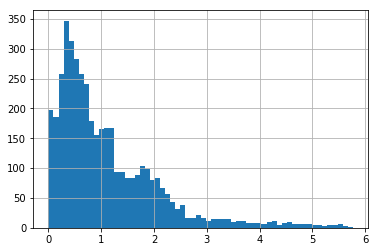

In [108]:
slip_b_df.slip.hist(bins=60)

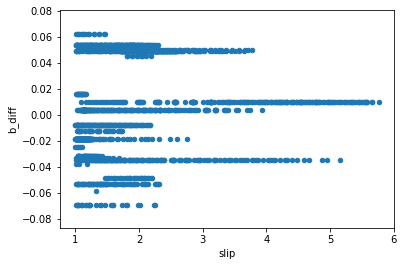

In [109]:
slip_b_df[slip_b_df.slip >= 1].plot(kind='scatter', x='slip', y='b_diff')

In [112]:
slip_b_df['slip_binned'] = slip_b_df.slip.apply(lambda x : round_nearest(x, 0.5))

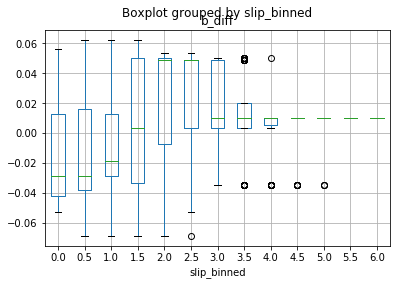

In [114]:
slip_b_df.boxplot(column='b_diff', by='slip_binned')

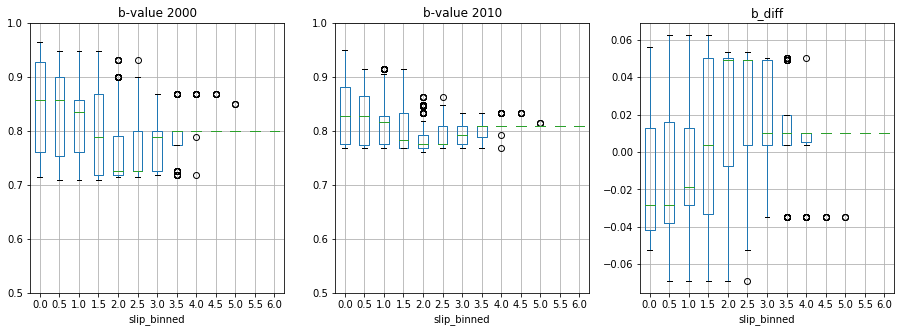

In [123]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

slip_b_df.boxplot(column='b_x', by='slip_binned', ax=ax)
slip_b_df.boxplot(column='b_y', by='slip_binned', ax=ax2)
slip_b_df.boxplot(column='b_diff', by='slip_binned', ax=ax3)
ax.set_ylim(0.5, 1.0)
ax2.set_ylim(0.5, 1.0)

ax.set_title('b-value 2000')
ax2.set_title('b-value 2010')


fig.suptitle('')

In [128]:
slip_b_df[slip_b_df.slip >= 1.].corr()

,lon,lat,radius_x,a_x,b_x,bstd_x,n_x,mc_x,radius_y,a_y,...,n_y,mc_y,b_diff,lat_old,lon_old,depth,slip,projected_lon,projected_lat,slip_binned
lon,1.000000,0.858508,NaN,-0.516046,0.915155,0.863188,-0.756113,0.257695,NaN,0.431632,...,0.402390,-0.606773,-0.843376,0.878158,0.990458,-0.687434,0.088171,0.990458,0.878269,0.085343
lat,0.858508,1.000000,NaN,-0.194694,0.939728,0.723080,-0.396972,0.031243,NaN,0.797163,...,0.791815,-0.825683,-0.925807,0.984765,0.867555,-0.370299,-0.008774,0.867555,0.984756,-0.019418
radius_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_x,-0.516046,-0.194694,NaN,1.000000,-0.432257,-0.769132,0.870994,-0.194731,NaN,0.285547,...,0.252820,0.341582,0.427785,-0.247903,-0.507983,0.528852,-0.242213,-0.507983,-0.248088,-0.246241
b_x,0.915155,0.939728,NaN,-0.432257,1.000000,0.892516,-0.625379,0.084865,NaN,0.636133,...,0.639747,-0.787870,-0.974979,0.941241,0.922495,-0.431109,-0.047596,0.922495,0.941361,-0.056810
bstd_x,0.863188,0.723080,NaN,-0.769132,0.892516,1.000000,-0.833775,0.221920,NaN,0.269867,...,0.296985,-0.657575,-0.874522,0.749887,0.862237,-0.524501,0.017921,0.862237,0.750077,0.014491
n_x,-0.756113,-0.396972,NaN,0.870994,-0.625379,-0.833775,1.000000,-0.193971,NaN,0.102039,...,0.141728,0.322254,0.559992,-0.448774,-0.744085,0.674698,-0.183667,-0.744085,-0.449002,-0.186252
mc_x,0.257695,0.031243,NaN,-0.194731,0.084865,0.221920,-0.193971,1.000000,NaN,-0.257176,...,-0.192512,0.225864,-0.019758,0.053620,0.224554,-0.415933,-0.058377,0.224554,0.053735,-0.056949
radius_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_y,0.431632,0.797163,NaN,0.285547,0.636133,0.269867,0.102039,-0.257176,NaN,1.000000,...,0.974544,-0.744960,-0.671463,0.758040,0.453645,0.035714,-0.125915,0.453645,0.757924,-0.144472
